In [3]:
import tensorflow as tf
import csv
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense,Dropout,Input,Conv2D,MaxPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from sklearn import metrics

2023-10-18 12:04:00.956777: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Data Loading

In [4]:
O_csv_file = 'labels4_374.csv'

In [5]:
data = pd.read_csv(O_csv_file)
data=data.drop('Age',axis=1)
data

,ID,Gender
0,ROI_9531160-02-R-20160302.jpg,1
1,ROI_4144311-05-L-20221227.jpg,2
2,ROI_4114625-08-L20230222.jpg,1
3,ROI_4288688-01-L-20190513.jpg,1
4,ROI_4274556-01-L-20220411.jpg,1
...,...,...
369,ROI_4114625-02-L-20160630.jpg,1
370,ROI_4304064-08-R-20180620.jpg,2
371,ROI_1049032-04-R-20151009.jpg,2
372,ROI_4376188-03-R-20220929.jpg,1


# Use Image (ROI only no CLAHE)

In [6]:
image_folder = '/home/john/network/Fundus/model/Color/dataset(select)/'

images = []

y = data['Gender'].values

for index, row in data.iterrows():
    image_id = row['ID'] 
    age = row['Gender']  

    image_path = os.path.join(image_folder, image_id)
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image_rgb, (392, 392))        # %75 small

    images.append(image)

In [7]:
# plt.imshow(images[0])
# plt.show()

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(images, data.Gender, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

#  Loading Xception model  weight

In [9]:
base_model = Xception(weights='imagenet', include_top=False,input_shape=(392,392,3)) 

2023-10-18 11:20:35.710040: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-10-18 11:20:35.738093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 11:20:35.738515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 849.46GiB/s
2023-10-18 11:20:35.738530: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-10-18 11:20:35.740703: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-10-18 11:20:35.740758: I tensorflow/stream_executor

# Model Building and Training

In [11]:
num_classes = 2

In [12]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid')) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 13, 13, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 20,994,762
Trainable params: 20,940,234
Non-trainable params: 54,528
_________________________________________________________________


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
X_train = np.array(X_train)
X_val = np.array(X_val)

QAQ = LabelEncoder()
y_train = to_categorical(QAQ.fit_transform(y_train))
y_val = to_categorical(QAQ.fit_transform(y_val))

In [15]:
num_epochs = 50
batch_size = 16  

train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_steps_per_epoch = len(X_train) // batch_size

val_datagen = ImageDataGenerator()
validation_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

validation_steps = len(X_val) // batch_size

In [16]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)

2023-10-18 11:21:00.253963: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-18 11:21:00.272560: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3187200000 Hz


Epoch 1/50


2023-10-18 11:21:01.680577: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-10-18 11:21:02.219225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8401
2023-10-18 11:21:02.867640: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-18 11:21:02.867656: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-10-18 11:21:02.867714: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-18 11:21:02.880478: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-10-18 11:21:02.880683: I tensorflow/stream_exec

18/18 [==============================] - 11s 412ms/step - loss: 0.6934 - accuracy: 0.5124 - val_loss: 0.6932 - val_accuracy: 0.5208
Epoch 2/50
18/18 [==============================] - 7s 365ms/step - loss: 0.6932 - accuracy: 0.5159 - val_loss: 0.6929 - val_accuracy: 0.6667
Epoch 3/50
18/18 [==============================] - 6s 356ms/step - loss: 0.6911 - accuracy: 0.5406 - val_loss: 0.7957 - val_accuracy: 0.5208
Epoch 4/50
18/18 [==============================] - 7s 378ms/step - loss: 0.6553 - accuracy: 0.6354 - val_loss: 48.8409 - val_accuracy: 0.6250
Epoch 5/50
18/18 [==============================] - 6s 354ms/step - loss: 0.6277 - accuracy: 0.6643 - val_loss: 65.2419 - val_accuracy: 0.5833
Epoch 6/50
18/18 [==============================] - 7s 375ms/step - loss: 0.5514 - accuracy: 0.7774 - val_loss: 22.2290 - val_accuracy: 0.5208
Epoch 7/50
18/18 [==============================] - 6s 357ms/step - loss: 0.5521 - accuracy: 0.7597 - val_loss: 21.7577 - val_accuracy: 0.5625
Epoch 8/50
1

In [14]:
# model.save("../model/save/Xecption-batch_size{}-epoch-{}.h5".format(batch_size,num_epochs))

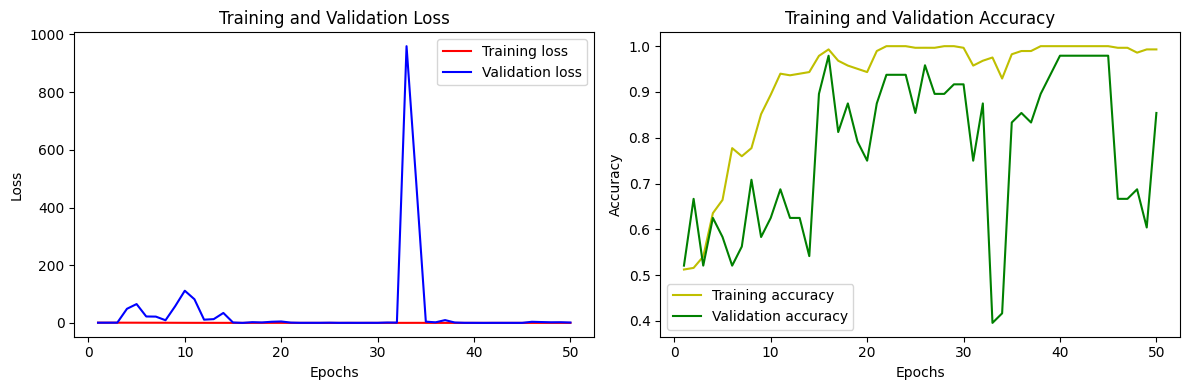

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# plt.savefig("../model/save/Xecption-batch_size{}-epoch-{}.jpg".format(batch_size,num_epochs))

In [16]:
X_train = np.array(X_train)
pred = model.predict(X_train)

<Figure size 640x480 with 0 Axes>

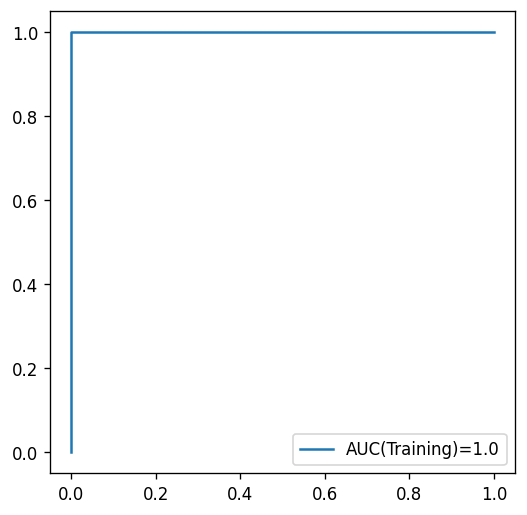

In [17]:
#set up plotting area
plt.figure(0).clf()
plt.figure(figsize=(5, 5), dpi=120)

#fit logistic regression model and plot ROC curv
fpr, tpr, _ = metrics.roc_curve(y_train[:,1], pred[:, 1])
auc = round(metrics.roc_auc_score(y_train[:,1], pred[:, 1]), 4)
plt.plot(fpr,tpr,label="AUC(Training)="+str(auc))


plt.legend()

In [18]:
# X_val = np.array(X_val)
# pred_y = model.predict(X_val)

In [19]:
# #set up plotting area
# plt.figure(0).clf()
# plt.figure(figsize=(5, 5), dpi=120)

# #fit logistic regression model and plot ROC curv
# fpr, tpr, _ = metrics.roc_curve(X_test[:,1], pred_y[:, 1])
# auc = round(metrics.roc_auc_score(X_test[:,1], pred_y[:, 1]), 4)
# plt.plot(fpr,tpr,label="AUC(Testing)="+str(auc))

# plt.legend()

In [3]:
Xmodel = tf.keras.applications.Xception(weights='imagenet')
Xmodel.summary()

2023-10-18 11:15:38.562999: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-10-18 11:15:38.585633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-18 11:15:38.585829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.665GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 849.46GiB/s
2023-10-18 11:15:38.585851: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-10-18 11:15:38.588739: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-10-18 11:15:38.588796: I tensorflow/stream_executor

91889664/91884032 [==============================] - 22s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_________________________

In [4]:
all_layers = Xmodel.layers
num_layers = len(all_layers)
print("Xception layers count :",num_layers)

Xception layers count : 134


In [6]:
from tensorflow.keras.regularizers import l2 

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(785, 785, 3), kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))  
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))) 
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))  
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))  
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))) 
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  # 
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(0.01)))  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 785, 785, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 392, 392, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 392, 392, 64)      18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 392, 392, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 196, 196, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 196, 196, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 196, 196, 128)    

In [10]:
all_layers = model.layers
num_layers = len(all_layers)
print("CNN layers count :",num_layers)

CNN layers count : 25
